# DQN (Deep Q-Network)

This is a jupyter tutorial for DQN (Deep Q-Network), a model-based algorithm for reinforcement learning.

## Requirements
- Pip for Python3
- GPU environment

## Setting
- Environment: Breakout in Atari games, using OpenAI Gym (https://gym.openai.com/)
- Framework for deep learning: PyTorch (https://pytorch.org/)

## Step1. Setup environment
In this step, we're going to install required modules. We use GPU environment (below we call remote) for training model, and need to share the same environment (i.e. installed modules) between local and remote. In this purpose, we use `pipenv`, a tool for package-managing and virtual environment.

### Step1.1. Setup pipenv for local
Run below commands in your local environment:

```
$ (local) pip3 install pipenv --user
$ (local) cd {project-directory}
$ (local) pipenv --python3
```

> When you encounter the error "pipenv: Command not found", run the following commands:
```
echo "export PATH=$HOME/.local/bin:$PATH" >> ~/.bash_profile
source ~/.bash_profile
```

Install required modules:

```
$ (local) pipenv install numpy
$ (local) pipenv install torch torchvision
$ (local) pipenv install gym gym[atari]
$ (local) pipenv install python-dotenv
$ (local) pipenv install matplotlib
```

Then log in virtual environment:
```
$ (local) pipenv shell
```

> To let this notebook work correctly, you should install additional modules in dev-packages:
```
$ (local) pipenv install jupyter --dev
$ (local) pipenv install 'ipykernel<5.0.0' --dev
```
> And start jupyter notebook in pipenv shell.

## Step2. Implementation
Now let's start implementation.

> Code below is revised for jupyter notebook (for module import/usage). Complete version is found in https://github.com/nosukeru/DQN_tutorial 

### Step2.1. Configuration
First, we setup some configuration for switching local/remote environment.

In [8]:
# config.py

import os
from dotenv import load_dotenv

load_dotenv('.env')
isLocal = (os.environ.get('ENV') == 'local')


And edit .env file:

```
# .env
ENV=local
```

### Step2.2. Implement Q-Network
Q-Network is a deep neural network model approximating Q-function, which represents potential total reward for current state and action under policy $\pi(a|s)$:

$$ Q^\pi(s, a) = r(s, a) + E_{s' \sim P(s'|s, a)} [V(s')] $$
$$ V^\pi(s) = E_{a \sim \pi(a|s)} [Q(s, a)] $$

When policy $\pi$ is optimal, the following Bellman equation holds:

$$ Q^\ast(s, a) = r(s, a) + E_{s' \sim P(s'|s, a)} [\max_{a'} Q^\ast(s', a')] $$

Our objective is to approximate optimal Q-function by deep neural network.
Here, we design Q-Network to take $s$ as an input and output a vector of Q-values corresponding to each $a$, because of calculation efficiency. Note that this is possible only when action space is countable and independent on state.

Below is an implementation of Q-Network using PyTorch. Input is a Torch tensor of stacked preprocessed frames of size (batch, 4, 84, 84) (detailed in later), and output is also a Torch tensor of Q-values corresponding actions. Architecture is following that of the original paper.

In [9]:
# models.py

import torch.nn as nn
import torch.nn.functional as F


# Q-Network model
class QNet(nn.Module):
    def __init__(self, nAction):
        # nAction: number of action (depends on gym environment)

        super(QNet, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)  # (4, 84, 84) -> (32, 20, 20)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)  # (32, 20, 20) -> (64, 9, 9)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)  # (64, 9, 9) -> (64, 7, 7)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, nAction)

    def forward(self, x):
        # run forward propagation
        # x: state (4 stacked grayscale frames of size 84x84)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(x.size(0), -1)))  # flatten
        return self.fc2(x)


### Step 2.3. Implement Policy

And when Q-function is optimal, best policy for given state $s$ is to select an action $a$ which maximizes Q-value:

$$ \pi(a|s) = \underset{a}{\operatorname{argmax}} Q(s, a) $$

To facilitate exploration, we use epsilon greedy in which agent takes action randomly with probability $\epsilon$.

In [10]:
# agents.py

import numpy as np
from torch.autograd import Variable


# agent (or policy) model
class Agent(object):
    def __init__(self, nAction, Q):
        # nAction: number of action (depends on gym environment)
        # Q: policy network

        self.nAction = nAction
        self.Q = Q

    def getAction(self, state, eps):
        # calc best action for given state
        # state: state (4 stacked grayscale frames of size 84x84)
        # eps: value for epsilon greeedy

        var = Variable(state)
        if not isLocal:
            var = var.cuda()

        # action with max Q value (q for value and argq for index)
        q, argq = self.Q(var).max(1) 

        # epsilon greedy
        probs = np.full(self.nAction, eps / self.nAction, np.float32)
        probs[argq[0]] += 1 - eps
        return np.random.choice(np.arange(self.nAction), p=probs)


### Step2.4. Implement Trainer
When it came to training network, there are some techniques to improve its stability and efficiency:

#### Replay Buffer
Saving trajectories to a memory and training network by samples randomly taken from this buffer has some benefits:

- enable batch training
- reduce correlation between experiences
- avoid forgetting previous experiences

#### Target network
The output of Q-Network is needed to calculate policy, so updating Q-Network always results to changing policy, which causes learning instability. In order to improve stability, We can use the copy of Q-Network for calculating policy, whose weights are fixed for a while.

In these techniques in mind, we can use the following mean squared loss as a learning objective:

$$ \sum_{i \in batch} \frac{1}{2} \{ Q(s_i, a_i) - (r_i + \max_{a'} Q_{target}(s'_i, a')) \} ^2 $$

where batch (s, a, r, s') = (state, action, reward, nextState) is sampled from ReplayBuffer.

If epsiode ends by the current action (game over), the next state is considered as a finish state and its Q-value is zero. In this case, the target becomes $r_i$ instead of $r_i + \max_{a'} Q_{target}(s'_i, a')$.

In [24]:
# trainers.py

import torch
import torch.nn as nn
from torch.autograd import Variable


# utility class for training Q-Network
class Trainer(object):
    def __init__(self, Q, QTarget, opt, gamma):
        # Q: Q-Network
        # QTarget: Target Q-Network
        # opt: optimizer

        self.Q = Q
        self.QTarget = QTarget
        self.opt = opt

        self.gamma = gamma
        self.lossFunc = nn.SmoothL1Loss()

    def update(self, batch):
        # update model for given batch
        # batch: training batch of (state, action, reward, nextState)

        # extract training batch
        stateBatch = Variable(torch.cat([step.state for step in batch], 0))
        actionBatch = torch.LongTensor([step.action for step in batch])
        rewardBatch = torch.Tensor([step.reward for step in batch])
        nextStateBatch = Variable(torch.cat([step.nextState for step in batch], 0))
        doneBatch = torch.Tensor([(1 if step.done else 0) for step in batch])

        if not isLocal:
            stateBatch = stateBatch.cuda()
            actionBatch = actionBatch.cuda()
            rewardBatch = rewardBatch.cuda()
            nextStateBatch = nextStateBatch.cuda()
            doneBatch = doneBatch.cuda()

        # calc values for update model
        qValue = self.Q(stateBatch).gather(1, actionBatch.unsqueeze(1)).squeeze(1)  # Q(s, a)
        qTarget = rewardBatch + (1 - doneBatch) * self.QTarget(nextStateBatch).detach().max(1)[0] * self.gamma  # r + γmaxQ(s', a')

        L = self.lossFunc(qValue, qTarget)  # loss to equalize Q(s) and r + γmaxQ(s', a')
        self.opt.zero_grad()
        L.backward()
        self.opt.step()  # train for one batch step



### Step 2.5. Implement Replay Buffer
Below is a code for naive implementation of Replay Buffer.

In [25]:
# utils.py

import random
from typing import NamedTuple

import torch
import torchvision.transforms as T


# one step of interaction with environment
class Step(NamedTuple):
    state: torch.Tensor
    action: int
    reward: float
    nextState: torch.Tensor
    done: bool


# replay buffer
class ReplayBuffer(object):
    def __init__(self, capacity):
        # capacity: max size of replay buffer

        self.capacity = capacity
        self.memory = []
        self.index = 0

    def push(self, step):
        # add  a step to buffer
        # step: one step of interaction

        if len(self.memory) < self.capacity:
            self.memory.append(step)
        else:
            self.memory[self.index] = step

        self.index = (self.index + 1) % self.capacity

    def sample(self, size):
        # collect batch of given size
        # size: batch size

        return random.sample(self.memory, size)


### Step 2.6. Implement preprocessing of frames
We also need some preprocessing of raw frames:

- resizing and trimming original frame of size (210, 160) into (84, 84) for less memory size
- grayscaling for simplicity

In [13]:
# utils.py

def preprocess(x):
    # preprocess frame
    # x: a frame of size 210x160
    
    # resize, grayscale and convert to tensor
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize(84),
        T.Grayscale(),
        T.ToTensor()
    ])

    return transform(x[50:, :, :]).unsqueeze(0)


### Step 2.7. Implement training loop
Finally we're ready to implement main training loop, but there're still some points to consider.

#### State as stacked frames
To capture the movement betweeen frames, it is beneficial to stack some frames as a state, instead of a single frame.

#### Action Repeat
Deciding action per each frame may be too frequent, because even expert (human player) can't decide action so quickly. In addition, state scarcely changes in adjacent frames and too many decision can result in training instability, so it can be helpful to skip some frames and take the same action as previous decision for these frames for speeding up and stabilize learning.

#### Training skip
Similar to frame skip, training per each frame can be too frequent and we'll train model one for some frames.

#### Replay Start
It is better not to start training until enough experiences are saved in ReplayBuffer to prevent overfitting.
Take random action while training doesn't began.

Below code is a full implementation of training process. Please make sure to make directory `/results` before running code.

```
$ (local) mkdir results
```

In [30]:
# train.py

import argparse

import gym
import torch
import torch.optim as optim


def train(args):
    # setup
    env = gym.make('Breakout-v0')

    nAction = env.action_space.n
    buffer = ReplayBuffer(args.buffer_size)

    Q = QNet(nAction)
    QTarget = QNet(nAction)

    if args.model_path is not None:
        state_dict = None
        if isLocal:
            state_dict = torch.load(args.model_path, map_location='cpu')
        else:
            state_dict = torch.load(args.model_path)

        Q.load_state_dict(state_dict)
        QTarget.load_state_dict(state_dict)

    Q.train()
    QTarget.eval()

    if not isLocal:
        Q = Q.cuda()
        QTarget = QTarget.cuda()

    opt = optim.Adam(Q.parameters(), lr=args.lr)

    agent = Agent(nAction, Q)
    trainer = Trainer(Q, QTarget, opt, args.gamma)

    t = 0
    action = 0  # no op
    start_t = time.time()

    for episode in range(args.episode):
        print("episode: %d\n" % (episode + 1))

        observation = env.reset()
        state = torch.cat([preprocess(observation)] * 4, 1)  # initial state
        sum_reward = 0
        initial_freeze = random.randint(0, args.initial_freeze_max)

        # Exploration loop
        done = False
        while not done:
            if isLocal:
                env.render()

            # replay start
            if t < args.replay_start:
                action = env.action_space.sample()
            # frame skip
            elif t % args.action_repeat == 0:
                alpha = t / args.exploration_steps
                eps = (1 - alpha) * args.initial_eps + alpha * args.final_eps
                eps = max(eps, args.final_eps)

                action = agent.getAction(state, eps)

            if initial_freeze > 0:
                action = 0  # no op
                initial_freeze -= 1

            # take action and calc next state
            observation, reward, done, _ = env.step(action)
            nextState = torch.cat([state.narrow(1, 1, 3), preprocess(observation)], 1)
            buffer.push(Step(state, action, reward, nextState, done))
            state = nextState
            sum_reward += reward
            t += 1

            # replay start
            if t < args.replay_start:
                continue

            # update model
            if t % args.train_freq == 0:
                batch = buffer.sample(args.batch)
                trainer.update(batch)

            # update target
            if t % args.target_update_freq == 0:
                QTarget.load_state_dict(Q.state_dict())

        print("  reward %.1f\n" % sum_reward)

        elapsed_minutes = (time.time() - start_t) / 60
        print("  elapsed %.1f min\n" % elapsed_minutes)
        print("  average %.2f min\n" % (elapsed_minutes / (episode + 1)))

        if episode % args.snapshot_freq == 0:
            torch.save(Q.state_dict(), "results/%d.pth" % episode)
            print("  model saved")

    torch.save(Q.state_dict(), "results/model.pth")
    env.close()


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--episode', type=int, default=12000)
    parser.add_argument('--buffer_size', type=int, default=1000000)
    parser.add_argument('--train_freq', type=int, default=4)
    parser.add_argument('--replay_start', type=int, default=50000)
    parser.add_argument('--batch', type=int, default=32)
    parser.add_argument('--target_update_freq', type=int, default=10000)
    parser.add_argument('--lr', type=float, default=0.00025)
    parser.add_argument('--action_repeat', type=int, default=4)
    parser.add_argument('--initial_freeze_max', type=int, default=30)
    parser.add_argument('--snapshot_freq', type=int, default=1000)
    parser.add_argument('--initial_eps', type=float, default=1.0)
    parser.add_argument('--final_eps', type=float, default=0.1)
    parser.add_argument('--exploration_steps', type=float, default=1000000)
    parser.add_argument('--gamma', type=float, default=0.99)
    parser.add_argument('--model_path', type=str)

    args = parser.parse_args(args=[])
    train(args)


episode: 1

  reward 1.0

  elapsed 0.0 min

  average 0.01 min

  model saved
episode: 2

  reward 1.0

  elapsed 0.0 min

  average 0.01 min

episode: 3

  reward 4.0

  elapsed 0.0 min

  average 0.01 min

episode: 4

  reward 3.0

  elapsed 0.1 min

  average 0.01 min

episode: 5

  reward 0.0

  elapsed 0.1 min

  average 0.01 min

episode: 6

  reward 3.0

  elapsed 0.1 min

  average 0.01 min

episode: 7

  reward 1.0

  elapsed 0.1 min

  average 0.01 min

episode: 8

  reward 0.0

  elapsed 0.1 min

  average 0.01 min

episode: 9

  reward 1.0

  elapsed 0.1 min

  average 0.01 min

episode: 10

  reward 0.0

  elapsed 0.1 min

  average 0.01 min

episode: 11

  reward 3.0

  elapsed 0.1 min

  average 0.01 min

episode: 12

  reward 0.0

  elapsed 0.1 min

  average 0.01 min

episode: 13

  reward 1.0

  elapsed 0.1 min

  average 0.01 min

episode: 14

  reward 0.0

  elapsed 0.1 min

  average 0.01 min

episode: 15

  reward 0.0

  elapsed 0.1 min

  average 0.01 min

episo

KeyboardInterrupt: 

## Step 3. Training in remote environment
Once you can confirm that training loop runs correctly in local environment, it's time to train model in remote environment with GPU.

### Step 3.1. Bring code into remote
You can use your own source repository, or forked repository of the following: https://github.com/nosukeru/DQN_tutorial.git

```
$ (remote) git clone {forked_repository_url}
```

### Step 3.2. Setup environment
You can install all required modules (and even Python of required version) through pipenv!

```
$ (remote) pip3 install pipenv --user
$ (remote) cd {project-directory}
$ (remote) pipenv install
```

> When you encounter the error "pipenv: Command not found", run the following commands:
```
echo "export PATH=$HOME/.local/bin:$PATH" >> ~/.bash_profile
source ~/.bash_profile
```

And edit .env file.
```
ENV=remote
```

### Step 3.3. Run training
All you need to do is run `train.py` in pipenv virtual environment.

```
$ (remote) mkdir results
$ (remote) pipenv shell
$ (remote) python3 src/train.py &> results/log.txt &
```

It will take about 7~8 hours. Once training finished, there are some saved model through `0.pth` ~ `11000.pth` and `model.pth` (full trained) in `/results` directory.

Note: Because there is still instability in training DQN, training may sometimes fail. You may have to try multiple times before training succeed.

## Step4. Evaluation
After successful training, let's evaluate trained model.

### Step4.1. (Optional) Bring trained model into local
```
$ (remote) git add results/log.txt results/model.pth
$ (remote) git commit -m "trained successfully"
$ (remote) git push origin master
```

```
$ (local) git pull origin master
```

### Step 4.2. Visualize training progress

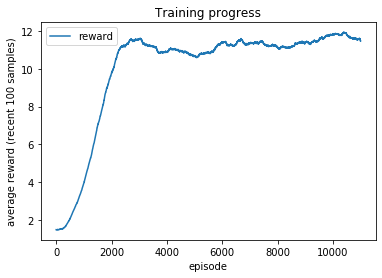

In [18]:
# test.py

import re
import matplotlib.pyplot as plt
%matplotlib inline


# extract rewards from log
def plot_progress(filename, label):
    N = 1000 # average num
    with open(filename, 'r') as f:
        log = f.read()

        pattern = re.compile(r'reward ([0-9.]+)')
        itr = pattern.finditer(log)
        rewards = [float(match.group(1)) for match in itr]
        averaged = [sum(rewards[i : i + N]) / N for i in range(len(rewards) - N)]

    plt.plot(averaged, label=label)

plot_progress('results/log.txt', 'reward')

plt.title('Training progress')
plt.xlabel('episode')
plt.ylabel('average reward (recent 100 samples)')
plt.legend()
plt.show()

### Step 4.3. Demonstrate agent's play
You can evaluate trained model qualitively by letting the agent play game actually.

In [31]:
# test.py

import argparse
import time

import gym
import torch


# demonstrate agent's play
def test(args):
    # setup
    env = gym.make('Breakout-v0')

    nAction = env.action_space.n

    Q = QNet(nAction)

    state_dict = None
    if isLocal:
        state_dict = torch.load(args.model_path, map_location='cpu')
    else:
        state_dict = torch.load(args.model_path)

    Q.load_state_dict(state_dict)
    Q.eval()

    if not isLocal:
        Q = Q.cuda()

    agent = Agent(nAction, Q)

    t = 0
    action = env.action_space.sample()
    for episode in range(args.episode):
        print("episode: %d\n" % (episode + 1))

        observation = env.reset()
        state = torch.cat([preprocess(observation)] * 4, 1)  # initial state
        sum_reward = 0

        # Exploration loop
        done = False
        while not done:
            if isLocal:
                env.render()

            action = agent.getAction(state, 0.01) # to avoid deadlock

            # take action and calc next state
            observation, reward, done, _ = env.step(action)
            nextState = torch.cat([state.narrow(1, 1, 3), preprocess(observation)], 1)

            state = nextState
            sum_reward += reward
            t += 1
            
            time.sleep(0.03)

        print("  reward %f\n" % sum_reward)

    env.close()


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--episode', type=int, default=20)
    parser.add_argument('--model_path', type=str, default='results/model.pth')

    args = parser.parse_args(args=[])
    test(args)

episode: 1

  reward 27.000000

episode: 2



KeyboardInterrupt: 

## Step5. Further improvements
So far we have successfully trained our model. There is still something you can do to improve our model in stability and performance:

### Decreasing epsilon
It is benefical to decrease epsilon as the training proceeds, controlling balance between exploration and exploitation.

In [10]:
def decreasing_eps(t):
    INTIAL_EPSILON = 1.0
    FINAL_EPSILON = 0.01
    EXPLORATION_STEPS = 1000000
    
    eps = FINAL_EPSILON
    if t < EXPLORATION_STEPS:
        alpha = t / EXPLORATION_STEPS
        eps = INITIAL_EPSILON * (1 - alpha) + FINAL_EPSILON * alpha
    
    return eps

### Use smoothed L1 loss
It may stabilize learning to use another loss function instead of MSE like following (Smoothed L1 loss):

$$
    L(e) =
        \begin{cases}
            \frac{1}{2} e^2 \quad |e| \le 1 \\
            |e|\quad |e| > 1 \\
        \end{cases}
$$

And gradient becomes:

$$
    \frac{\partial}{\partial w} L(e) =
        \begin{cases}
            e \frac{\partial e}{\partial w} \quad |e| \le 1 \\
            sign(e) \frac{\partial e}{\partial w} \quad |e| > 1 \\
        \end{cases}
$$



This is a similar technique as gradient clipping.

### Randomized action for initial frames
If initial state is fixed and transition is determistic, the agent can make the same trajectory repeatedly. Randomizing the first some actions can result in collecting improved variety of trajectories and data efficiency.

### Parameterized policy
Above we used simple epsilon-greedy algorithm for policy, but parametering policy by another neural network will enable more flexible and complicated strategy. This improvement will result in methods called DDPG (Deep Deterministic Policy Gradient) or Actor-Critic.

### Results of technique comparison

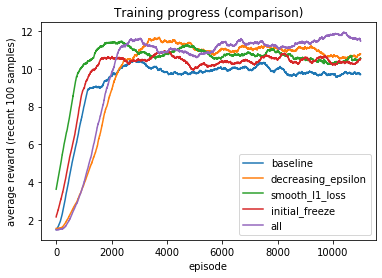

In [33]:
plot_progress('results/log_baseline.txt', 'baseline')
plot_progress('results/log_epsilon.txt', 'decreasing_epsilon')
plot_progress('results/log_l1.txt', 'smooth_l1_loss')
plot_progress('results/log_freeze.txt', 'initial_freeze')
plot_progress('results/log_master.txt', 'all')

plt.title('Training progress (comparison)')
plt.xlabel('episode')
plt.ylabel('average reward (recent 100 samples)')
plt.legend()
plt.show()